In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier

In [12]:
# Import df and extract elements
df = pd.read_csv("synthetic_fraud_dataset.csv")

df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Create balanced dataset
fraud_df = df[df['Fraud_Label'] == 1]
nonfraud_df = df[df['Fraud_Label'] == 0]
nonfraud_sampled = nonfraud_df.sample(n=16067, random_state=42)

# Combine and shuffle
df_balanced = pd.concat([fraud_df, nonfraud_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Drop identifier columns
df_balanced = df_balanced.drop(['Transaction_ID', 'User_ID'], axis=1)

# 3. Timestamp feature engineering
df_balanced['Timestamp'] = pd.to_datetime(df_balanced['Timestamp'])
df_balanced['Hour'] = df_balanced['Timestamp'].dt.hour
df_balanced['DayOfWeek'] = df_balanced['Timestamp'].dt.dayofweek
df_balanced['Is_Night'] = (df_balanced['Hour'] < 6).astype(int)
df_balanced = df_balanced.drop('Timestamp', axis=1)

# 4. Encode categorical features
categorical_cols = ['Transaction_Type', 'Device_Type', 'Location', 
                    'Merchant_Category', 'Card_Type', 'Authentication_Method']

for col in categorical_cols:
    df_balanced[col] = LabelEncoder().fit_transform(df_balanced[col])

# 5. Fill missing values
df_balanced = df_balanced.fillna(df_balanced.median(numeric_only=True))

# 6. Drop known leakage features
X = df_balanced.drop(['Previous_Fraudulent_Activity', 'Risk_Score', 'Fraud_Label'], axis=1)
y = df_balanced['Fraud_Label']

# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# 8. Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
# ORIGINAL STACKED MODEL (Untuned)
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier  # or use LightGBM if needed

# Base models
rf_base = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced', random_state=42)
mlp_base = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=200, random_state=42)
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=3, random_state=42)

base_models_original = [
    ('rf', rf_base),
    ('xgb', xgb_base),
    ('mlp', mlp_base)
]

meta_model = LogisticRegression()

# Stacked model (original)
stacked_original = StackingClassifier(
    estimators=base_models_original,
    final_estimator=meta_model,
    n_jobs=1  # avoid macOS multiprocessing issues
)

stacked_original.fit(X_train_scaled, y_train)

# Evaluate
y_pred_orig = stacked_original.predict(X_test_scaled)
y_prob_orig = stacked_original.predict_proba(X_test_scaled)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print("Original Model Report:\n", classification_report(y_test, y_pred_orig))
print("Original Model ROC AUC:", roc_auc_score(y_test, y_prob_orig))

/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:23:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:23:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:23:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learne

Original Model Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84      4017
           1       0.99      0.62      0.77      4017

    accuracy                           0.81      8034
   macro avg       0.86      0.81      0.80      8034
weighted avg       0.86      0.81      0.80      8034

Original Model ROC AUC: 0.806376918509578


In [16]:
from sklearn.model_selection import GridSearchCV

# Tuning Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

grid_search_rf.fit(X_train_scaled, y_train)
best_rf = grid_search_rf.best_estimator_
print("Best Random Forest Parameters:", grid_search_rf.best_params_)

# Tuning MLPClassifier
param_grid_mlp = {
    'hidden_layer_sizes': [(64,), (64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(max_iter=300, random_state=42)

grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

grid_search_mlp.fit(X_train_scaled, y_train)
best_mlp = grid_search_mlp.best_estimator_
print("Best MLP Parameters:", grid_search_mlp.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.6s
[CV] END max_depth=10, min_sam

/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive; total time=   6.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive; total time=   6.6s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant; total time=   9.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive; total time=   9.2s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant; total time=   9.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant; total time=   9.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant; total time=   6.0s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant; total time=   6.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant; total time=   6.4s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive; total time=   6.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive; total time=   6.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive; total time=   9.5s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive; total time=   9.5s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive; total time=   6.8s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant; total time=  10.0s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant; total time=  10.3s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant; total time=   7.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant; total time=  10.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant; total time=   7.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=constant; total time=   7.3s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive; total time=  10.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive; total time=  10.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive; total time=   7.1s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive; total time=  10.4s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive; total time=   7.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate=adaptive; total time=   7.8s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant; total time=   6.5s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant; total time=   8.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant; total time=   8.8s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant; total time=   8.3s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive; total time=  11.4s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant; total time=  11.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive; total time=  11.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive; total time=   7.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=adaptive; total time=  11.5s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=constant; total time=   8.0s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive; total time=   6.3s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate=adaptive; total time=   6.3s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant; total time=   8.6s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant; total time=   8.9s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=constant; total time=   8.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive; total time=   8.1s


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive; total time=   8.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), learning_rate=adaptive; total time=   8.2s
Best MLP Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'learning_rate': 'constant'}


In [17]:
# NEW STACKED MODEL (Tuned)
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

base_models_tuned = [
    ('rf', best_rf),
    ('mlp', best_mlp)
    # You can optionally add your tuned XGB here if you tune it
]

meta_model_tuned = LogisticRegression()

stacked_tuned = StackingClassifier(
    estimators=base_models_tuned,
    final_estimator=meta_model_tuned,
    n_jobs=-1
)

stacked_tuned.fit(X_train_scaled, y_train)

# Evaluate tuned model
y_pred_tuned = stacked_tuned.predict(X_test_scaled)
y_prob_tuned = stacked_tuned.predict_proba(X_test_scaled)[:, 1]

print("Tuned Model Report:\n", classification_report(y_test, y_pred_tuned))
print("Tuned Model ROC AUC:", roc_auc_score(y_test, y_prob_tuned))

/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Tuned Model Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84      4017
           1       1.00      0.62      0.77      4017

    accuracy                           0.81      8034
   macro avg       0.86      0.81      0.80      8034
weighted avg       0.86      0.81      0.80      8034

Tuned Model ROC AUC: 0.8114599955417259


In [18]:
print(y_test.value_counts())

Fraud_Label
0    4017
1    4017
Name: count, dtype: int64


/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/parshvamehta/Fraud-Detect/fraud-detect/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

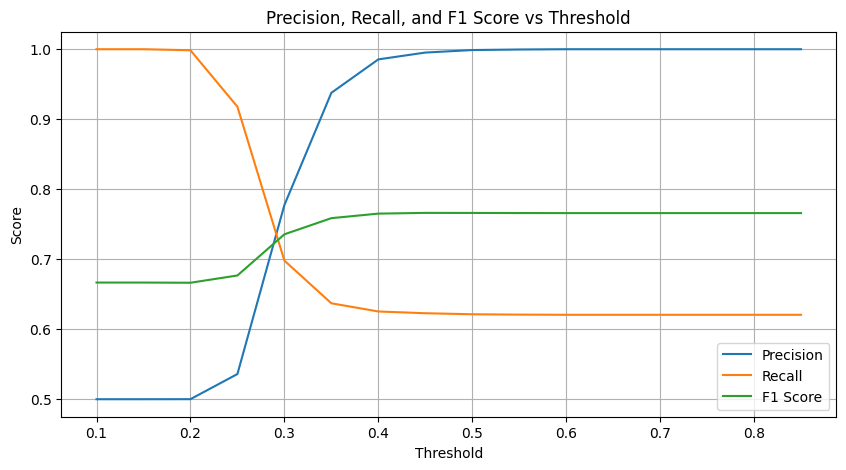

In [19]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# 1. Get predicted probabilities from the tuned model
y_probs = stacked_tuned.predict_proba(X_test_scaled)[:, 1]

# 2. Try different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
scores = []

for t in thresholds:
    preds = (y_probs >= t).astype(int)
    report = classification_report(y_test, preds, output_dict=True)
    f1 = report['1']['f1-score']
    recall = report['1']['recall']
    precision = report['1']['precision']
    scores.append((t, precision, recall, f1))

# 3. Plot Precision-Recall vs Threshold
thresholds_plot = [x[0] for x in scores]
precisions = [x[1] for x in scores]
recalls = [x[2] for x in scores]
f1s = [x[3] for x in scores]

plt.figure(figsize=(10, 5))
plt.plot(thresholds_plot, precisions, label='Precision')
plt.plot(thresholds_plot, recalls, label='Recall')
plt.plot(thresholds_plot, f1s, label='F1 Score')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs Threshold")
plt.legend()
plt.grid()
plt.show()

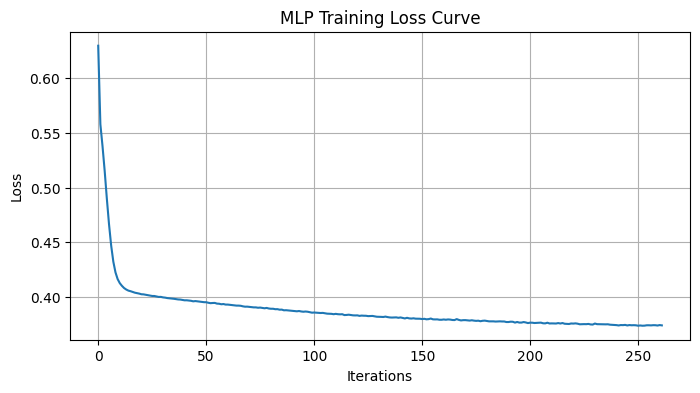

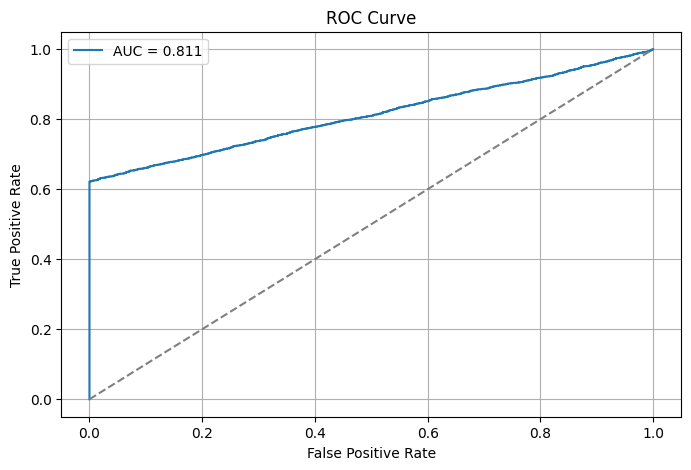

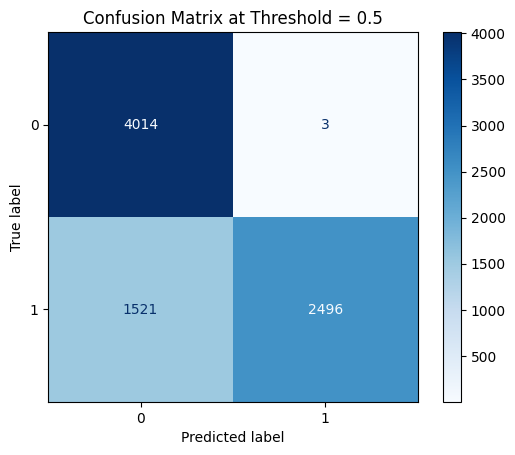

In [20]:
import matplotlib.pyplot as plt

# Only works if you've used an MLPClassifier directly (not in a stack)
mlp_model = best_mlp  # or use your tuned MLP from grid search

plt.figure(figsize=(8, 4))
plt.plot(mlp_model.loss_curve_)
plt.title("MLP Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Get model prediction probabilities (for class 1)
y_probs = stacked_tuned.predict_proba(X_test_scaled)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_probs):.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix (default 0.5 threshold)
y_pred_default = (y_probs >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_default)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix at Threshold = 0.5")
plt.grid(False)
plt.show()